In [1]:
%matplotlib inline

In [2]:
import sys
sys.path.insert(0, "../")
sys.path.insert(0, "../dataset_generation/")

import json
import torch
import numpy as np
import scipy.signal
import matplotlib.pyplot as plt

plt.style.use("project_style.mplstyle")

import stats
import scipy.stats
from tqdm import tqdm
import analysis_tools as tools

from numba import jit

In [3]:
sequences = 500
timesteps = 500

sequence = ["square", "walled_square"]
#sequence = ["square", "square"]

res = 16
bins = [[res, res] for i in range(len(sequence))]

In [4]:
# load model and specs
model_name = "al1_10_l2_0"
path = f"../models/{model_name}"
model, params = tools.load_model(path, device = "cpu", model_type = "RNN")

In [5]:
model

VPC_RNN(
  (g): RNN(8, 500, bias=False, batch_first=True)
  (p): Linear(in_features=500, out_features=100, bias=False)
  (activation): ReLU()
  (loss_fn): MSELoss()
)

In [6]:
xa, ra, va, ca = tools.test_dataset(sequences*[sequence[0]], timesteps, context = params["context"], 
                                    device = "cpu", trajectories = True)
xb, rb, vb, cb = tools.test_dataset(sequences*[sequence[1]], timesteps, context = params["context"], 
                                    device = "cpu", trajectories = True)
ra.shape, va.shape, ca.shape

((500, 500, 2), (500, 500, 2), (500, 500, 6))

In [7]:
gs = []
ps = []
g_prev = None
for x in (xa, xb):
    yhat, g, p, mu = model(x, g_prev = g_prev)
    g_prev = g[:,-1]
    gs.append(g.detach().numpy())
    ps.append(p.detach().numpy())

gs = np.concatenate(gs, axis = 1)
ps = np.concatenate(ps, axis = 1)
rs = np.concatenate([ra, rb], axis = 1)

In [8]:
# only consider active units!
g_mask = np.mean(gs, axis = (0, 1)) > 0
p_mask = np.mean(ps, axis = (0, 1)) > 0

gs = gs[...,g_mask]
ps = ps[...,p_mask]
gs.shape, ps.shape, rs.shape

((500, 1000, 131), (500, 1000, 100), (500, 1000, 2))

In [9]:
g_ratemaps = np.zeros((2*timesteps, gs.shape[-1], res, res)).astype("float32")
p_ratemaps = np.zeros((2*timesteps, ps.shape[-1], res, res)).astype("float32")

In [10]:
def autocorr(x):
    z = np.zeros((len(x), len(x)))
    for i in range(len(x)):
        for j in range(len(x)):
            z[i, j] = np.corrcoef(x[i], x[j])[1,0]
    return z

In [11]:
for i in range(2*timesteps):
    p_ratemaps[i] = stats.ratemaps(ps[None,:,i], rs[None,:,i], bins, smooth = True)
    g_ratemaps[i] = stats.ratemaps(gs[None,:,i], rs[None,:,i], bins, smooth = True) 

In [12]:
g_corr = autocorr(g_ratemaps.reshape((g_ratemaps.shape[0], -1)))

In [13]:
p_corr = autocorr(p_ratemaps.reshape((p_ratemaps.shape[0], -1)))

In [14]:
p_min, g_min = np.amin(p_corr), np.amin(g_corr)

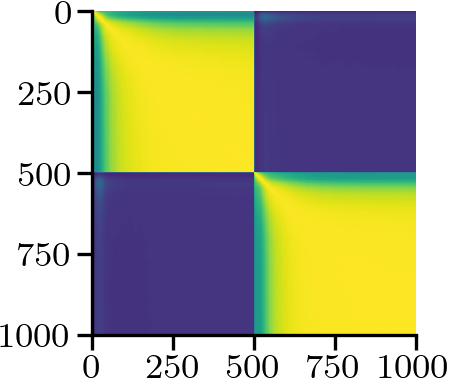

In [15]:
plt.figure(figsize=(1.4, 1.4))
plt.imshow(g_corr, vmin = g_min, vmax = 1)
plt.xticks(np.linspace(0, g_corr.shape[0], 5).astype("int"))
plt.yticks(np.linspace(0, g_corr.shape[1], 5).astype("int"))

plt.savefig("./figures/g_autocorr")

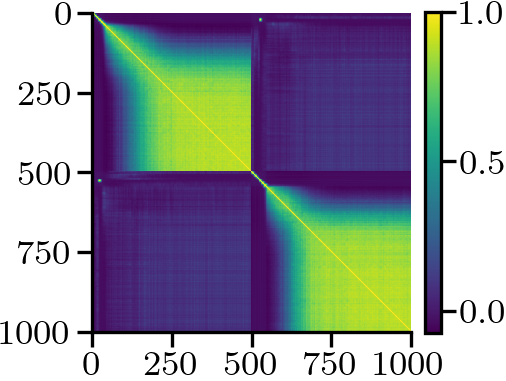

In [16]:
plt.imshow(p_corr, vmin = p_min, vmax = 1)
plt.xticks(np.linspace(0, g_corr.shape[0], 5).astype("int"))
plt.yticks(np.linspace(0, g_corr.shape[1], 5).astype("int"))

plt.colorbar(fraction=0.046, pad=0.04)
plt.savefig("./figures/p_autocorr")